# POC Reimplementation of Model Logic

The original implementation of the NBCU tagger used a BERT tokenizer from HuggingFace. The main limitation of this approach is that tokenization had to be performed **before** the tfx pipeline, so the tokenizer wasn't actually incorporated into the model. The result of this is that tokenization steps would have to be performed manually on the serving side as well by loading in the same tokenizer. This reimplmentation of the same logic would make maintenance more difficult and could potentially cause training-serving skew. 

Fortunately, there are a lot of BERT models (with their accompanying tokenizers) on [TFHUB](https://www.tensorflow.org/hub). This notebook is basically just following [this tutorial](https://www.tensorflow.org/tutorials/text/classify_text_with_bert#about_bert), but for the NBCU data. The goal is just to get a feel for how to use TFHub and get an idea of whether using TFHub instead of hugging face would actually work. 

Let's test TFHub! 

In [ ]:
!pip install --user tensorflow_text

In [1]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as tf_text
import numpy as np

We have some data previously used for training we can test out. 

In [2]:
test_data = pd.read_parquet('gs://metadata-bucket-sky/series_data.parquet')

In [3]:
test_data.columns

Index(['program_seriesid', 'program_longsynopsis', 'program_title',
       'Action & Adventure', 'Animals', 'Animated', 'Anime', 'Art', 'Auto',
       'Biography', 'Business & Finance', 'Children's/Family Entertainment',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Educational',
       'Entertainment', 'Fantasy', 'Fashion', 'Fishing', 'Food', 'Game Show',
       'Health', 'History', 'Home & Garden', 'Home improvement', 'How-To',
       'Interview', 'Legal', 'Medical', 'Music', 'Mystery', 'Nature', 'News',
       'Outdoors', 'Politics & Government', 'Public Affairs', 'Reality',
       'Religion', 'Romance', 'Science & Technology', 'Science fiction',
       'Shopping', 'Sitcom', 'Soap Opera', 'Sports', 'Talk', 'Thriller',
       'Travel', 'kids (ages 5-9)', 'not for kids', 'older teens (ages 15+)',
       'preschoolers (ages 2-4)', 'teens (ages 13-14)', 'tweens (ages 10-12)'],
      dtype='object')

Not all of these are present?
```python
labels = ['Action & Adventure', 'Animated', 'Anime', 'Biography', "Children's/Family Entertainment", 'Comedy', 'Courtroom', 'Crime', 'Documentary', 'Drama', 'Educational', 'Fantasy', 'Gay and Lesbian', 'History', 'Holiday', 'Horror', 'Martial arts', 'Military & War', 'Music', 'Musical', 'Mystery', 'Romance', 'Science fiction', 'Sports', 'Thriller', 'Western', 'kids (ages 5-9)', 'not for kids', 'older teens (ages 15+)', 'preschoolers (ages 2-4)', 'teens (ages 13-14)', 'tweens (ages 10-12)']
```

The model used previously is [DistilBERT from huggingface](https://huggingface.co/transformers/model_doc/distilbert.html). This exact model is not available on TFHub. One thing worth exploring in the future could be the differences between DistillBERT vs. smallbert and ALBERT models on TFHub. 

In [4]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [5]:
%%time
all_text = test_data['program_longsynopsis'].values[:100]
text_preprocessed = bert_preprocess_model(all_text)

CPU times: user 1.02 s, sys: 220 ms, total: 1.24 s
Wall time: 986 ms


In [6]:
text_preprocessed

{'input_mask': <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
 array([[ 101, 2893, 2000, ...,    0,    0,    0],
        [ 101, 3228, 4283, ...,    0,    0,    0],
        [ 101, 1037, 2158, ...,    0,    0,    0],
        ...,
        [ 101, 2381, 1998, ...,    0,    0,    0],
        [ 101, 6662, 9703, ...,    0,    0,    0],
        [ 101, 2013, 6708, ...,    0,    0,    0]], dtype=int32)>}

In [7]:
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1')
text_preprocessed_small = {key: val for key, val in text_preprocessed.items()}
bert_encodings = bert_model(text_preprocessed_small)

In [8]:
bert_encodings

{'pooled_output': <tf.Tensor: shape=(100, 512), dtype=float32, numpy=
 array([[ 9.8826951e-01,  7.2769499e-01, -2.6808077e-01, ...,
         -8.8120566e-04, -4.1904831e-01, -8.5811907e-01],
        [ 2.0680071e-01,  9.3880767e-01,  1.7131691e-01, ...,
          4.0066573e-01, -1.2563021e-01,  6.1843377e-01],
        [ 9.9883622e-01,  9.1495574e-01,  2.2518414e-01, ...,
          4.7290269e-01, -2.8145000e-01,  4.7164500e-01],
        ...,
        [ 9.9656183e-01,  9.9642932e-01, -2.8435415e-01, ...,
         -2.6539739e-02, -3.9831248e-01,  3.4861189e-01],
        [ 9.8267496e-01,  9.9400222e-01, -4.8110452e-01, ...,
          5.5820722e-02, -7.4261492e-01, -9.8915744e-01],
        [ 9.9778593e-01,  8.5658854e-01, -4.3400198e-02, ...,
          4.7763687e-01,  6.3283309e-02,  4.3264684e-01]], dtype=float32)>,
 'encoder_outputs': [<tf.Tensor: shape=(100, 128, 512), dtype=float32, numpy=
  array([[[-0.07861047, -0.36692545, -0.02081838, ..., -0.82692593,
            0.00960982, -0.058295

Seems very, very easy to use. Let's do an actual training run to see what happens. 

--- 
# Create Dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_df, eval_df = train_test_split(test_data, test_size=0.2, random_state=42)

In [11]:
def make_dataset(df, shuffle=False, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((df['program_longsynopsis'].values, df.iloc[:, 3:]))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size=batch_size)
    
    return dataset

In [12]:
train_dataset = make_dataset(train_df, shuffle=True)
eval_dataset = make_dataset(eval_df, shuffle=False)

In [13]:
for data, label in train_dataset.take(1):
    print(data)

tf.Tensor(
[b'OnDemand Movie'
 b'Join Spike Davis and his crew of kids on fun filled trips each episode as they explore grown up occupations.'
 b"Tio Beto refuses to endorse Miguel's ascension to power; a general wishes to renegotiate his terms; Agent Delia Flores redoubles her efforts to find a killer. A vengeful husband incarcerates Chato on phony charges; Agent Flores stumbles into another agent's territory. Miguel learns his wife has kept a dangerous secret from him; a European doctor claims a new drug will increase the cartel's fortune; Chato begins an affair with a married woman. Miguel makes a multimillion-dollar deal with a heroin kingpin in Thailand; Dr. Klein's estranged wife demands a large cash settlement. A powerful Mexican family in an illegal drug cartel faces challenges in a dangerous underworld and from the U.S. Drug Enforcement Agency. Chato puts the business and his brother's family at risk when he seeks revenge against Police Chief Lazareno."
 b'From the University 

In [14]:
tfhub_handle_preprocess =  "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
n_tags = 53 # Don't know why its so high rn

def build_bert_tagger():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='synopsis')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    output = tf.keras.layers.Dense(n_tags, activation="sigmoid")(net)
    return tf.keras.Model(text_input, output)

In [16]:
classifier_model = build_bert_tagger()
bert_raw_result = classifier_model(data)
print(bert_raw_result)

tf.Tensor(
[[0.6077992  0.77086616 0.5151147  ... 0.6386155  0.13013881 0.5152784 ]
 [0.74761474 0.85716665 0.7815692  ... 0.6910137  0.19038793 0.67475307]
 [0.6293908  0.8379962  0.77892494 ... 0.29731396 0.45403358 0.8450453 ]
 ...
 [0.6401373  0.88790184 0.64276344 ... 0.37502035 0.11135184 0.652455  ]
 [0.614477   0.6970325  0.29873806 ... 0.81892896 0.17942548 0.6986166 ]
 [0.58786035 0.79525995 0.6896304  ... 0.40142888 0.26688    0.73928165]], shape=(32, 53), dtype=float32)


Bert uses a special optimizer (AdamW). Right now we're just doing something super simple, but may want to fix this when we do our training runs "for real". 

In [17]:
# May need to fix this? 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00003,
                                     clipnorm=1,
                                     epsilon=1e-8)

metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
classifier_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=metrics,
)

In [18]:
history = classifier_model.fit(train_dataset,
                              validation_data=eval_dataset,
                              epochs=3)

Epoch 1/3


3181/3181 [==============================] - 814s 253ms/step - loss: 0.1223 - precision: 0.4832 - recall: 0.1855 - val_loss: 0.0660 - val_precision: 0.7538 - val_recall: 0.4447
Epoch 2/3
3181/3181 [==============================] - 805s 253ms/step - loss: 0.0645 - precision: 0.7672 - recall: 0.4472 - val_loss: 0.0629 - val_precision: 0.7392 - val_recall: 0.4903
Epoch 3/3
3181/3181 [==============================] - 805s 253ms/step - loss: 0.0582 - precision: 0.7812 - recall: 0.5061 - val_loss: 0.0627 - val_precision: 0.7351 - val_recall: 0.5028


In [19]:
from matplotlib import pyplot as plt

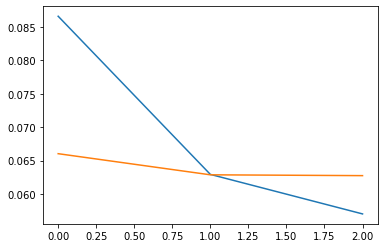

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [21]:
predictions = classifier_model.predict(eval_dataset)

In [22]:
predictions

array([[2.8922982e-03, 2.3184487e-04, 3.7736096e-03, ..., 9.7416101e-05,
        1.3445156e-02, 2.3572810e-03],
       [2.1326410e-02, 1.2743390e-03, 8.6595543e-04, ..., 9.8629738e-05,
        2.4747623e-03, 2.9263981e-03],
       [5.2640648e-03, 2.0044746e-03, 3.6648435e-03, ..., 1.4182162e-03,
        1.5422697e-03, 2.0434365e-03],
       ...,
       [3.0793529e-04, 4.8002028e-03, 7.5046206e-04, ..., 5.0761335e-04,
        3.0892243e-04, 4.6912025e-04],
       [3.0467398e-03, 8.4759924e-04, 5.3977332e-04, ..., 3.3587279e-05,
        6.4386078e-04, 4.1572319e-04],
       [1.7184999e-03, 1.0669011e-03, 7.2318915e-04, ..., 2.9400116e-04,
        1.1323704e-03, 5.6505958e-03]], dtype=float32)

In [23]:
def compare_random(df, predictions):
    idx = np.random.choice(len(df))
    instance= eval_df.iloc[idx]
    
    print(instance['program_longsynopsis'])
    
    frame = pd.concat([instance[3:], predictions.iloc[idx]], axis=1)
    frame.columns = ['actual', 'predicted']
    
    return frame.sort_values(by='predicted', ascending=False)

In [49]:
eval_df = eval_df.reset_index(drop=True)
predictions_df = pd.DataFrame(predictions, columns=eval_df.columns[3:])

Seems to work very well! 

In [55]:
frame = compare_random(eval_df, predictions_df)
display(frame)

Improving education in California. Barry Munitz details the goals and results of Governor Gray Davis' special legislative session on education. Improving public education in California.


,actual,predicted
Public Affairs,1,0.869831
Politics & Government,0,0.142910
Talk,0,0.085736
Educational,1,0.059804
News,0,0.046406
Documentary,0,0.013703
Health,0,0.008564
Business & Finance,0,0.006913
Interview,0,0.005391
Legal,0,0.004966


In [46]:
predictions_df.columns = [col + '_pred' for col in eval_df.columns[3:]]
output_df = pd.concat((eval_df, predictions_df), axis=1)

In [47]:
output_df.to_parquet('gs://nbcu-metadata-enhancement/sample_predictions.parquet')